In [2]:
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 50, "display.max_columns", 10)


In [3]:
# load the dataframe with 11 year SPX 1 Day OHLC data and other custom columns based around those OHLC data
df = pd.read_pickle('../../dfs/1min_spx_max_iv_rth.pkl')
df_size = len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1543924 entries, 0 to 1543923
Data columns (total 27 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   date            1543924 non-null  datetime64[ns]
 1   open            1543924 non-null  float64       
 2   high            1543924 non-null  float64       
 3   low             1543924 non-null  float64       
 4   close           1543924 non-null  float64       
 5   iv_open         1543924 non-null  float64       
 6   iv_high         1543924 non-null  float64       
 7   iv_low          1543924 non-null  float64       
 8   iv_close        1543924 non-null  float64       
 9   volume          1543924 non-null  float64       
 10  average         1543924 non-null  float64       
 11  barCount        1543924 non-null  int64         
 12  prev_close      1543924 non-null  float64       
 13  iv_prev_close   1543924 non-null  float64       
 14  open_close      15

In [1]:
# print and plot the data for quick validation that the data appear intact and as expected.
print(f"mean real_vol:           {df['real_vol'].mean():.2f}%")
print(f"max real_vol:            {df['real_vol'].max():.2f}%")
print(f"median real_vol:         {df['real_vol'].median():.2f}%")
print(f"median daily movement:   {100 * df['open_close'].abs().median():.3f}%")
print(f"mean close_open:         {100 * df['close_open'].abs().mean():.3f}%")
print(f"median close_open:       {100 * df['close_open'].abs().median():.3f}%")
print(f"iv open mean:            {100 * df['iv_open'].mean():.2f}%")
print(f"iv open median:          {100 * df['iv_open'].median():.2f}%")

df.plot('date', 'open')
df.plot('date', 'iv_open')
df.plot('date', 'close_open')
df.plot('date', 'iv_close_close')
df.plot('date', 'real_vol')
df.plot('date', 'max_vol')

NameError: name 'df' is not defined

<AxesSubplot:xlabel='date'>

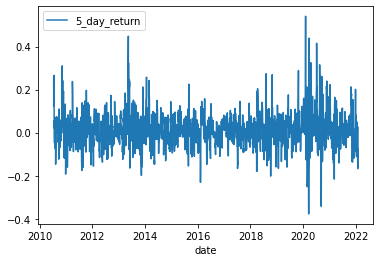

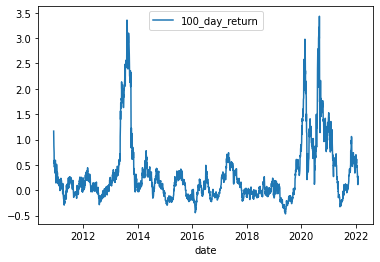

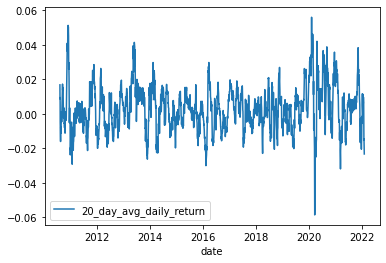

In [7]:
# shift(1) is to prevent look-ahead bias
df['1_day_return'] = (df['close'].shift(1) - df['open'].shift(2)) / df['open'].shift(2)
df['20_day_avg_daily_return'] = df['1_day_return'].shift(1).rolling(20).mean()
df['5_day_return'] = (df['close'].shift(1) - df['open'].shift(5)) / df['open'].shift(5)
df['10_day_return'] = (df['close'].shift(1) - df['open'].shift(10)) / df['open'].shift(10)
df['15_day_return'] = (df['close'].shift(1) - df['open'].shift(15)) / df['open'].shift(15)
df['20_day_return'] = (df['close'].shift(1) - df['open'].shift(20)) / df['open'].shift(20)
df['50_day_return'] = (df['close'].shift(1) - df['open'].shift(50)) / df['open'].shift(50)
df['100_day_return'] = (df['close'].shift(1) - df['open'].shift(100)) / df['open'].shift(100)
df.plot('date', '5_day_return')
df.plot('date', '100_day_return')
df.plot('date', '20_day_avg_daily_return')

In [42]:
print(df['iv_open'].mean())

0.536987921629426


In [4]:
"""<---   begin tunable parameters   --->"""
"""======================================"""
# Underlying-specific parameters:
# below is for SPX. For SPY, for example, min_tick = 0.01, spread_loss = 0.01, min_risk = 0.05

# * the position, option, derived, default position prefixes to the below vars 
#   is just to identify where those vars should live in the class-based redesign.

position_spread_loss = 0.15         # bid-ask spread losses on a trade. Quoted as a % of opening position value
position_min_tick = 0.05            # [CONSTANT] the minimum spread tick for SPX options is $0.05; add to all long legs.
position_min_risk = 0.02            # [CONSTANT] spot movement in % beyond 2 SD (for unhedged positions) in fudge_factor()
position_min_strike_gap = 5         # [CONSTANT] minimum strike width of SPX options is 5

# Position parameters:
option_is_credit = True          # False for DEBIT (long), True for CEDIT (short)
derived_is_hedged = False          # no hedging positions. naked short if credit else long only for debit
option_tenor = 5                 # trading days until expiry, not calendar days
option_hp = 50                    # holding period, inclusive of opening day 0 and closing day. hp=0 is o-c same-day
position_stop_loss = -0.8           # risk return threshold to close a position below.
position_scalping = False               # close a position upon reaching a defined level of profit
position_pom_threshold = None       # Percent of Max possible return scalping threshold, supercedes
default_position_rr_threshold = 1.5        # Risk Return threshold to close the position upon reaching
default_position_sequential = True          # simulates a real environment where only 1 position will be open at a time
default_position_r = 0.01                   # [CONSTANT] risk-free rate for BSM calculations
default_position_days = {0, 1, 2, 3, 4}     # for filtering the opening trading day of the week. 0 = Mon, 4 = Fri

# Optionally test on a subset of dates:
default_position_full_df = True             # supersedes start, end, AND training set. Will use entire df.
position_training_set = False        # supersedes start, end. automatically trains on past 11 years
# start = '2020-03-27'       # [optional] 'YYYY-MM-DD' format date. used to narrow the DF to a specific range
# end = '2022-03-01'         # [optional] end date for the narrowing range
# start, end = '2008-01-01', '2009-01-01'  # bear run
# start, end = '2020-03-27', '2021-08-27'  # bull run

# call parameters:
option_call_coef = '0.05 SD'       # relative distance OTM for strike. 'x' for constant multiplier, 'SD' for std dev.
derived_call_gap = 40              # call strike gap; distance between long and short call strikes
derived_call_inside = False        # True: force hedging strikes to be inside of coef. False: allow hedges further OTM
# TODO: for optimization loop, omit the inside flag since it's redundant if you're trying all combinations.

# put parameters:
option_put_coef = '0.05 SD'        # relative distance OTM for strike. 'x' for constant multiplier, 'SD' for std dev.
derived_put_gap = 50               # put strike gap; distance between long and short put strikes
derived_put_inside = False         # force the furthest OTM strike (either long or short) is no further than coef OTM

# Parameters for filtering realized volatility
vol_threshold = 0.02          # threshold value for realized volatility, combines with the below two filters.
lookback = 3               # trading days for the rolling realized volatility lookbacks
vol_greater_than = True    # False changes the direction to real_vol.rolling() (<) vol_threshold from (>)
use_max = True             # use max_vol (high-low) or real_vol (open-close)

# Parameters for filtering implied volatility
position_iv_min_threshold = 0.0    # lower bound for iv open
position_iv_max_threshold = 0.60    # upper bound for iv open
default_position_iv_greater_than = False     # if False, no MIN iv filtering will happen
default_position_iv_less_than = True       # if False, no MAX iv filtering will happen

# Misc. parameters:
default_position_sample = False             # Random sample valid rows. 0 < sample < 1: % of df. sample > 1: n=sample.
default_position_return_only = False        # just return the output instead of printing or plotting the data.
default_position_lrr_only = False           # return only (lrr, num_winners) from passthrough()
default_position_plot = True                # plot position performance (PoM and RR over HP + histograms for both)
default_position_analyze = False            # run the linear regression and scatter plot analysis (analyze_results())
default_position_silently = True            # used by find_max_losers() and get_true_lrr()
default_position_return_tally = True        # used by find_max_losers()
"""======================================"""
"""<---    end tunable parameters    --->"""

if training_set:
    # disregard above values for start and end,
    # force the testing to be on the following days:
    start, end = '2006-01-01', '2018-01-01'
if full_df:
    # supercedes training_set and any start or end
    # from above, forcing the entire df to be used.
    start, end = None, None
hp = min(hp, tenor)  # force hp <= tenor
if not put_coef:
    put_gap = 0
if not call_coef:
    call_gap = 0

output = passthrough(spread_loss, min_tick, min_risk, min_strike_gap, is_credit, is_hedged, tenor, hp,
                     call_coef=call_coef, call_gap=call_gap, call_inside=call_inside, put_coef=put_coef,
                     put_gap=put_gap, put_inside=put_inside, stop_loss=stop_loss, scalping=scalping,
                     pom_threshold=pom_threshold, rr_threshold=rr_threshold, sequential=sequential,
                     r=r, days=days, start=start, end=end, vol_threshold=vol_threshold, lookback=lookback,
                     vol_greater_than=vol_greater_than, use_max=use_max, iv_min_threshold=iv_min_threshold,
                     iv_max_threshold=iv_max_threshold, iv_greater_than=iv_greater_than,
                     iv_less_than=iv_less_than, sample=sample, return_only=return_only, lrr_only=lrr_only,
                     plot=plot)

lrr = output[0]
num_valid_days = output[1]
num_winners = output[2]
p = output[3]
b = output[4]
c = output[5]
pdf = output[6]
expected_return = output[7]
wager = output[8]
subset_size = output[9]

mean_move = pdf['spot_movement'].abs().mean()          # median is more useful than mean.    
median_move = pdf['spot_movement'].abs().median()      # median is more useful than mean.

# print(pdf.iloc[:10][['date', 'pvo', 'pvc', 'coef', 'true_return',
#                      'pom_return', 'risk_return']])  # DAT

# plt.hist(pdf['spot_movement'], bins=len(pdf)//2 + 5, histtype='stepfilled')
# plt.axvline(mean_move, color='k', linestyle='dashed', linewidth=1)
# plt.axvline(median_move, color='r', linestyle='solid', linewidth=1)
# plt.show()

print(pdf.iloc[-10:][['date', 'coef', 'risk_return', 'pvo', 'iv_open']])

if analyze:
    analyze_results(pdf)

strat_name = get_strat_name(is_credit, call_coef, put_coef)
max_consecutive_days = find_max_losers(pdf, silently=silently, return_tally=return_tally)
# consecutive_failures = get_consecutive_failures(max_consecutive_days, duration, sequential=sequential)
# true_lrr, bsm_lrr = get_true_lrr(pdf, wager, b, sequential=sequential, silently=silently)


print('=====================================')
print(f"REPORT FOR {strat_name.upper()}:")
print('-------------------------------------')
# print(consecutive_failures)
print(f'\n{100*num_valid_days/(subset_size - hp - lookback):.1f}% of days meet criteria ({num_valid_days})')
print(f'hp = {hp} trading (~{round(7/5*hp)} calendar) days')
print('-------------------------------------')
print(f"median spot movement:         {100 * median_move:.2f}%")
print(f"mean spot movement:           {100 * mean_move:.2f}%")
print('-------------------------------------')
print(f"probability of a win:         {100 * p:.2f}%")
print(f"payout for winners:           {100 * b:.2f}%")
print(f"loss for losers:              {100 * c:.2f}%")
print(f'expected_return:              {100 * expected_return:.2f}%')
print(f'wager:                        {100 * wager:.2f}%')
print(f'wager expected_return:        {100 * wager * expected_return:.2f}%')
print(f'average expected lrr:         {100 * lrr:,.0f}%')
# print('-------------------------------------')
# print(f'true computed lrr:            {100 * true_lrr:,.0f}%')
# print(f'computed bsm lrr:             {100 * bsm_lrr:,.0f}%')
# print(f'$100,000 at true lrr:        ${100000 * (1 + true_lrr):,.0f}')
print('-------------------------------------')
print(f"mean iv open:                 {100 * pdf['iv_open'].mean():.2f}")
print(f"median iv open:               {100 * pdf['iv_open'].median():.2f}")
print('-------------------------------------')
print(f"cumulative risk return:       {100 * pdf['risk_return'].sum():.2f}%")
print(f"highest risk return:          {100 * pdf['risk_return'].max():.2f}%")
print(f"mean risk return:             {100 * pdf['risk_return'].mean():.2f}%")  # !NOTE: this == expected_return!
print(f"median risk return:           {100 * pdf['risk_return'].median():.2f}%")
print('=====================================')

NameError: name 'passthrough' is not defined

In [17]:
import numpy as np

In [108]:
a = np.ones((4, 4))
strike_idx = 2

a[:, strike_idx] = 123.21
# a[:, 4, 0] = 5.5
a.shape

(4, 4)

In [109]:
holding_period = 4
a = np.repeat(a[:, :, np.newaxis], holding_period, axis=2)
a.shape

(4, 4, 4)

In [110]:
a

array([[[  1.  ,   1.  ,   1.  ,   1.  ],
        [  1.  ,   1.  ,   1.  ,   1.  ],
        [123.21, 123.21, 123.21, 123.21],
        [  1.  ,   1.  ,   1.  ,   1.  ]],

       [[  1.  ,   1.  ,   1.  ,   1.  ],
        [  1.  ,   1.  ,   1.  ,   1.  ],
        [123.21, 123.21, 123.21, 123.21],
        [  1.  ,   1.  ,   1.  ,   1.  ]],

       [[  1.  ,   1.  ,   1.  ,   1.  ],
        [  1.  ,   1.  ,   1.  ,   1.  ],
        [123.21, 123.21, 123.21, 123.21],
        [  1.  ,   1.  ,   1.  ,   1.  ]],

       [[  1.  ,   1.  ,   1.  ,   1.  ],
        [  1.  ,   1.  ,   1.  ,   1.  ],
        [123.21, 123.21, 123.21, 123.21],
        [  1.  ,   1.  ,   1.  ,   1.  ]]])

In [111]:
a[:, strike_idx, :]

array([[123.21, 123.21, 123.21, 123.21],
       [123.21, 123.21, 123.21, 123.21],
       [123.21, 123.21, 123.21, 123.21],
       [123.21, 123.21, 123.21, 123.21]])

In [114]:
a[:, 2 :, :]

array([[[123.21, 123.21, 123.21, 123.21],
        [  1.  ,   1.  ,   1.  ,   1.  ]],

       [[123.21, 123.21, 123.21, 123.21],
        [  1.  ,   1.  ,   1.  ,   1.  ]],

       [[123.21, 123.21, 123.21, 123.21],
        [  1.  ,   1.  ,   1.  ,   1.  ]],

       [[123.21, 123.21, 123.21, 123.21],
        [  1.  ,   1.  ,   1.  ,   1.  ]]])

In [115]:
a.shape

(4, 4, 4)

In [129]:
a[:, :4, :].shape

(4, 3, 4)

In [126]:
def set_to_5(a: np.ndarray) -> None:
    a[:, :, :] = 5

In [127]:
set_to_5(a)

In [128]:
a

array([[[5., 5., 5., 5.],
        [5., 5., 5., 5.],
        [5., 5., 5., 5.],
        [5., 5., 5., 5.]],

       [[5., 5., 5., 5.],
        [5., 5., 5., 5.],
        [5., 5., 5., 5.],
        [5., 5., 5., 5.]],

       [[5., 5., 5., 5.],
        [5., 5., 5., 5.],
        [5., 5., 5., 5.],
        [5., 5., 5., 5.]],

       [[5., 5., 5., 5.],
        [5., 5., 5., 5.],
        [5., 5., 5., 5.],
        [5., 5., 5., 5.]]])

In [33]:
def print_df(df, is_credit):
    print(df[['winner', 'open_position_value', 'close_position_value', 'bsm_return']])
#     if is_credit:
        # print(df[['date', 'winner', 'put_k', 'call_k', 'end_iv']])
#         print(df[['date', 'spot_movement']])

#     else:
#         print(df[['open_position_value', 'min_position_value', 'close_position_value', 'bsm_return']])
#         print(df[['date', 'open_position_value']])


In [256]:
# plot a subset of the df
subset = get_subset('2007-01-01', '2010-03-01')
subset.plot('date', 'open')
subset.plot('date', 'iv_open')
subset.plot('date', 'close_close')
subset.plot('date', 'max_vol')

In [8]:
# find the mean and median absolute movement over a period of time
duration = 30
pdf = df[:]
pdf['duration_move'] = (pdf['close'].shift(-duration) - pdf['open']) / pdf['open']

# optional filters below...
pdf = pdf[pdf['iv_open'] >= 0.25]
pdf = pdf[pdf['iv_open'] < 0.40]
pdf.reset_index(inplace=True, drop=True)
print(len(pdf))

# pdf.plot('date', 'duration_move')
mean_move = pdf['duration_move'].abs().mean()
median_move = pdf['duration_move'].abs().median()

print(f"mean movement:          ±{100 * mean_move:.2f}%")  # show the intraday open-close movement
print(f"median movement:        ±{100 * median_move:.2f}%")  # show the intraday open-close movement


551
mean movement:          ±5.74%
median movement:        ±5.01%


# assumptions
1. the max loss will occur at one of (open, hp)
1. special things tend to happen around the stikes or the extreme spot movements
1. the relative strike that yields the max loss/return for one position should apply to all others (meaning they don't need the same monte carlo simulation)
1. identifying positive entry criteria can prevent needless calculation on many inputs that don't match
1. if the max value occurs at close or deep itm, sigma is not significantly important

In [75]:
import numpy as np
import math
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

def price_call(s, k, t, sigma, r = 0.04) -> float:
    # from Hull p. 335, fig. (15.20)
    d1 = get_d1(s, k, r, sigma, t)
    d2 = get_d2(d1, sigma, t)
    call = s * norm.cdf(d1) - k * math.exp(-r * t) * norm.cdf(d2)
    return max(0, call)


def price_put(s, k, t, sigma, r = 0.04) -> float:
    # from Hull p. 335, fig (15.21)
    d1 = get_d1(s, k, r, sigma, t)
    d2 = get_d2(d1, sigma, t)
    put = k * math.exp(-r * t) * norm.cdf(-d2) - s * norm.cdf(-d1)
    return max(0, put)


def get_d1(spot, strike, r, sigma, t) -> float:
    # BUG: runtime warning from numpy division by zero.
    return ((math.log(spot / strike) + (r + sigma ** 2 / 2) * t) /
            (sigma * math.sqrt(t) + 0.001))


def get_d2(d1, sigma, t) -> float:
    return d1 - sigma * math.sqrt(t)

starting:	 201.01429309846912
max loss:	 514.0696798859478 at: 4700 sigma: 0.015172034242919318 tenor: 0.09445303417103673


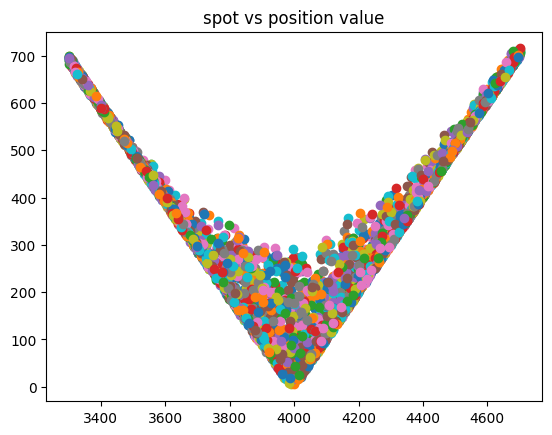

In [86]:
#  max loss calculations from 50 to 1M simulations
#        50 max loss:	 467.08606283895995 at: 3329 sigma: 0.21633739752030073 tenor: 0.01812798254545261
#       500 max loss:	 496.42226533867824 at: 3300 sigma: 0.23530193248374492 tenor: 0.01602528110883155
#     1_000 max loss:    497.87148080167776 at: 3300 sigma: 0.08433989709071459 tenor: 0.006963519079320686
#    10_000 max loss:    495.8129332135243 at: 3302 sigma: 0.047132041449180095 tenor: 0.007329546123287335
#   100_000 max loss:	 498.22250123245635 at: 3300 sigma: 0.20251855260460797 tenor: 0.004769126527463039
# 1_000_000 max loss:	 498.79980781633026 at: 3300 sigma: 0.16212522956199468 tenor: 0.0011605324521117412

k1, k2, hp = 4000, 4000, 25
downswing, upswing = 3300, 4700
value = starting = price_call(4000, k1, hp/252, 0.2) + price_put(4000, k2, hp/252, 0.2)
ml_spot, ml_sigma, ml_tenor = 4000, 0.2, 25
for _ in range(5000):
    t = random.random() * hp/252 + 0.00001
    sigma = random.random() * 32 / 100
    spot = random.randint(downswing, upswing)
    v = price_call(spot, k1, t, sigma) + price_put(spot, k2, t, sigma)
    plt.scatter(spot, v)
    if v > value:
        value = v
        ml_spot, ml_sigma, ml_tenor = spot, sigma, t
print("starting:\t", starting)
print("max loss:\t", value - starting, "at:", ml_spot, "sigma:", ml_sigma, "tenor:", ml_tenor)
plt.title(f"spot vs position value")
plt.show()

In [1185]:
def estimate_comp_time():
    # * Estimate the computation time for the optimization
    #   loop with the below parameters.
    # * this isn't perfect, since, for example, if not scalping,
    #   pom_threshold and rr_threshold are useless and not used.
    # parameters:
    is_credit = 1            # (bool)
    is_hedged = 1            # (bool)
    tenor = 1               # (0, 60)
    hp = 1                  # (0, 60)
    call_coef = 25           # (0.95, 1.2, 0.01)
    put_coef = 1            # (0.75, 1.0, 0.01)
    call_gap = 15            # (5, 50, 5)
    put_gap = 1             # (5, 50, 5)
    vol_threshold = 5       # (0, 5, 0.25)
    lookback = 5            # (1, 15, 1)
    vol_greater_than = 1     # (bool)
    use_max = 1              # (bool)
    iv_min_threshold = 1    # (0, 0.30, 0.025)
    iv_max_threshold = 1    # (0.01, 0.40, 0.025)
    iv_greater_than = 1      # (bool)
    iv_less_than = 1         # (bool)
    scalping = 1             # (bool)
    pom_threshold = 1       # (0.15, 0.90, 0.05)
    rr_threshold = 1        # (0.15, 2.0, 0.05)
    
    passthrough_time = 0.5
    comp_time_s = (passthrough_time * is_credit * is_hedged *
                   tenor * hp * call_coef * put_coef * call_gap *
                   put_gap * vol_threshold * lookback * vol_greater_than *
                   use_max * iv_min_threshold * iv_max_threshold * iv_greater_than *
                   iv_less_than * scalping * pom_threshold * rr_threshold)
    comp_time_m = comp_time_s / 60
    comp_time_h = comp_time_m / 60
    comp_time_d = comp_time_h / 24
    return f'{comp_time_m:,.0f}'

estimate_comp_time()

'78'

In [737]:
# taken from the `cds` notebook threshold_optimize():
30 * 10 * 25 * 10 * 0.0512

3750.0

In [ ]:
# output_df = pd.DataFrame(columns=['duration', 'coef', 'lookback', 'pcs_threshold', 'b'])
# print(list(output_df))
# find the max for each threshold

def optimize():
    # NOTE: this calculation takes ~5-10 minutes to run
    opt_duration = 0
    opt_coef = 0
    opt_lookback = 0
    opt_threshold = 0
    opt_b = 0
    opt_num_winners = 0
    max_output = 0
    for duration in range(1, 10):
        for coef in range(990, 1015, 1):
            coef /= 1000
            b = estimate_b(duration, coef)
            for threshold in range(1, 20):
                threshold /= 10
                # originally (10, 20)
                # sigma threshold
                # before changing thresholds, append the max output from the previous threshold
                for lookback in range(0, 10):
                    output = passthrough(duration, coef, b, lookback, threshold)
                    lrr = output[0]
                    num_winners = output[1]
                    if lrr > max_output:
#                         print(output)
                        max_output = lrr
                        opt_duration = duration
                        opt_coef = coef
                        opt_lookback = lookback
                        opt_threshold = threshold
                        opt_b = b
                        opt_num_winners = num_winners
    print(f'optimal duration: {opt_duration}')
    print(f'optimal coef: {opt_coef}')
    print(f'optimal lookback: {opt_lookback}')
    print(f'optimal threshold: {opt_threshold}')
    print(f'optimal b: {opt_b}')
    print(f'optimal num_winners: {opt_num_winners}')
    print(f'lrr: {max_output}')